In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import copy


In [2]:
def create_mnist_data(class_splits, split_index, csv_file="mnist.csv", image_shape=(1, 28, 28)):
    df = pd.read_csv(csv_file)
    all_classes = sorted(df['label'].unique())
    start_class = sum(class_splits[:split_index])
    end_class = start_class + class_splits[split_index]
    valid_classes = all_classes[start_class:end_class]

    filtered_df = df[df['label'].isin(valid_classes)]
    X = filtered_df.drop(columns=['label']).values
    y = filtered_df['label'].values
    label_mapping = {cls: i for i, cls in enumerate(valid_classes)}
    y = np.array([label_mapping[label] for label in y])

    X = torch.tensor(X / 255.0, dtype=torch.float32).view(-1, *image_shape)
    y = torch.tensor(y, dtype=torch.long)

    return TensorDataset(X, y)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2, 2)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [4]:
def train_model(model, data_loader, criterion, optimizer, epochs, device):
    """
    Trains a given model.
    """
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        with tqdm(total=len(data_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit="batch") as pbar:
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
                pbar.set_postfix(loss=total_loss / (pbar.n + 1))
                pbar.update(1)



In [5]:
def inference(models, combined_loader, class_splits, index=None):
    """
    Performs inference using all models efficiently, handling uneven class splits.
    """
    all_preds = []
    all_labels = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Store logits from all models
    all_logits = [None] * len(models)

    for model_idx, model in enumerate(models):
        model.eval()
        model_logits = []

        with torch.no_grad():
            for batch_idx, (images, _) in enumerate(combined_loader):
                images = images.to(device)
                if len(images.shape) == 3:
                    images = images.unsqueeze(1)

                # If index is provided, infer only that index
                if index is not None:
                    images = images[index].unsqueeze(0)

                logits = model(images)  # Get raw logits
                model_logits.append(logits.cpu())  # Store logits on CPU to save GPU memory

                if index is not None:
                    break

        # Concatenate all batches for this model
        all_logits[model_idx] = torch.cat(model_logits, dim=0)  # Shape: (num_samples, num_classes_per_model)

    # Convert logits list to NumPy for fast computation
    all_logits_np = [logits.numpy() for logits in all_logits]
    num_samples = all_logits[0].shape[0]  # Total number of samples

    # Find the best class across all models for each sample
    for i in range(num_samples):
        max_confidence = -float("inf")
        best_class = None

        for model_idx, logits in enumerate(all_logits_np):
            if i >= logits.shape[0]:  # If dataset sizes are uneven
                continue

            confidence = np.max(logits[i])  # Max logit value
            pred = np.argmax(logits[i])  # Class prediction

            # Offset to match global label space
            global_class = pred + sum(class_splits[:model_idx])

            if confidence > max_confidence:
                max_confidence = confidence
                best_class = global_class

        all_preds.append(best_class)

    # Get true labels from the loader
    for _, labels in combined_loader:
        all_labels.extend(labels.cpu().numpy())
        if index is not None:
            break

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(sum(class_splits))))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(range(sum(class_splits))),
                yticklabels=list(range(sum(class_splits))))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    print(cm)


In [21]:
# --- Main Execution ---
class_splits = [2,2,2,2,2]
image_shape = (1, 28, 28)
batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\n")

models = []
data_loaders = []

criterion = nn.CrossEntropyLoss()

for i, num_classes in enumerate(class_splits):
    dataset = create_mnist_data(class_splits, i, image_shape=image_shape)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    data_loaders.append(loader)
    print(f"Training model {i} with {num_classes} classes")
    model = SimpleCNN(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(model, loader, criterion, optimizer, epochs=5, device=device)
    models.append(model)

print("\nTraining complete. Evaluating group model...")

Using device: cuda

Training model 0 with 2 classes


Epoch 5/5: 100%|██████████| 138/138 [00:00<00:00, 149.06batch/s, loss=0.00015]


Training model 1 with 2 classes


Epoch 5/5: 100%|██████████| 134/134 [00:00<00:00, 183.49batch/s, loss=0.00827]


Training model 2 with 2 classes


Epoch 5/5: 100%|██████████| 123/123 [00:00<00:00, 158.48batch/s, loss=0.00107]


Training model 3 with 2 classes


Epoch 5/5: 100%|██████████| 134/134 [00:00<00:00, 180.07batch/s, loss=8.83e-5]


Training model 4 with 2 classes


Epoch 5/5: 100%|██████████| 129/129 [00:00<00:00, 165.77batch/s, loss=0.00995]


Training complete. Evaluating group model...



Overall Accuracy: 75.99%


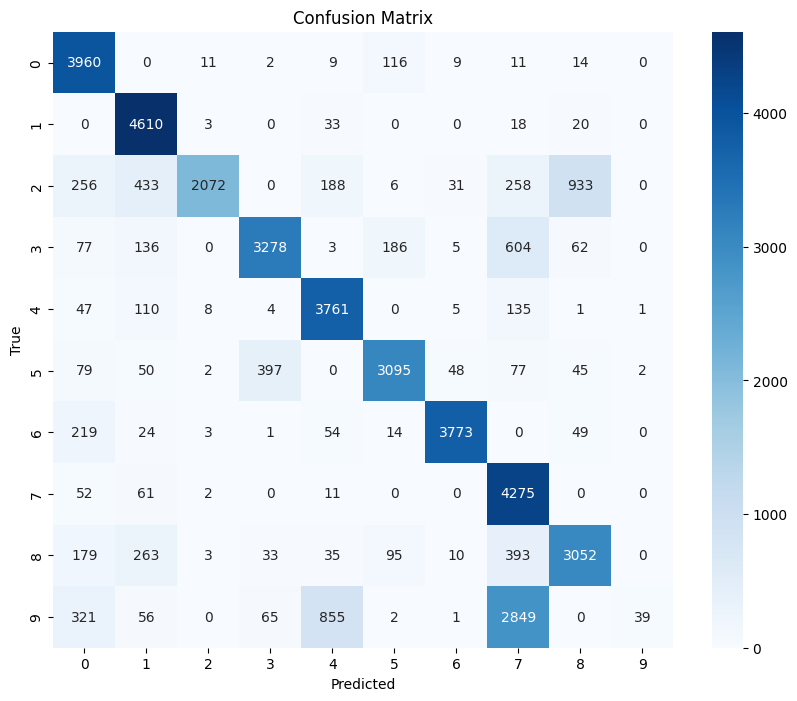

[[3960    0   11    2    9  116    9   11   14    0]
 [   0 4610    3    0   33    0    0   18   20    0]
 [ 256  433 2072    0  188    6   31  258  933    0]
 [  77  136    0 3278    3  186    5  604   62    0]
 [  47  110    8    4 3761    0    5  135    1    1]
 [  79   50    2  397    0 3095   48   77   45    2]
 [ 219   24    3    1   54   14 3773    0   49    0]
 [  52   61    2    0   11    0    0 4275    0    0]
 [ 179  263    3   33   35   95   10  393 3052    0]
 [ 321   56    0   65  855    2    1 2849    0   39]]


In [22]:
combined_loader = DataLoader(create_mnist_data([sum(class_splits)], 0, image_shape=image_shape), batch_size=batch_size)
inference(models, combined_loader, class_splits)


In [23]:
class CombinedCNN(nn.Module):
    def __init__(self, models, class_splits):
        super(CombinedCNN, self).__init__()
        self.models = nn.ModuleList(models)  # Use pre-trained models
        self.total_classes = sum(class_splits)

    def forward(self, x):
        batch_size = x.size(0)
        outputs = []
        for model in self.models:
            logits = model(x)  # Each model processes the same input
            outputs.append(logits)

        # Concatenate logits from all models
        combined_output = torch.cat(outputs, dim=1)  # Shape: (batch_size, total_classes)
        return combined_output

    def describe_model(self):
        print("\n=== CombinedCNN Model Description ===")
        print(f"Total number of classes: {self.total_classes}")
        print(f"Number of submodels: {len(self.models)}")
        for i, model in enumerate(self.models):
            print(f"\nSubmodel {i + 1} (handling {class_splits[i]} classes):")
            print(model)
        print("\n====================================\n")

# Combine pre-trained models
combined_model = CombinedCNN(models, class_splits).to(device)

# Describe the model
combined_model.describe_model()

# Inference with the combined model
def inference_combined(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Overall Accuracy: {accuracy * 100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()



=== CombinedCNN Model Description ===
Total number of classes: 10
Number of submodels: 5

Submodel 1 (handling 2 classes):
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Submodel 2 (handling 2 classes):
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

Submodel 3 (handling 2 classes):
SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (

Overall Accuracy: 75.99%


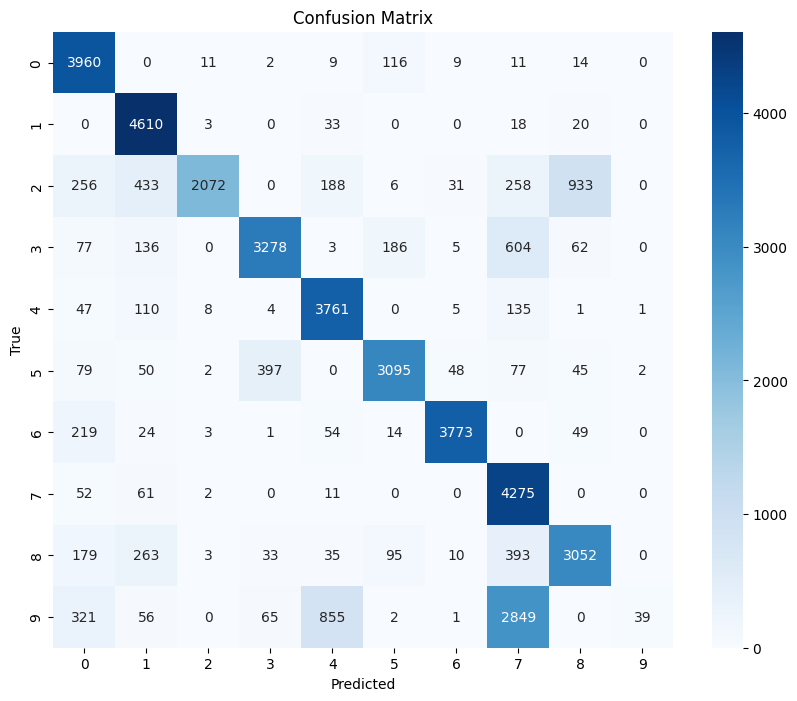

In [25]:
inference_combined(combined_model, combined_loader)